In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
from StringIO import StringIO
from collections import Counter
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib2
import re

In [2]:
###Define a function to caculate the ChIP-seq signal in each bin of corresponding Hi-C matrix######
def computeMatrix(bedfile,boundarylist,chrn,winsize,res,chrs_l,tabfile):
    blist = boundarylist[(boundarylist>winsize)&(boundarylist<(chrs_l-winsize*res)/res)].astype(int)
    mm = np.zeros((len(blist),2*winsize+1))
    chrinfo = tabfile.loc[bedfile[0]==chrn]
    for i in range(0,len(blist)):
        mm[i,:]=chrinfo.iloc[blist[i]-winsize:blist[i]+winsize+1,4].values
    return mm

In [3]:
def getlevel(tads):
    ftads = tads[(tads[:,1]-tads[:,0]).argsort()[::-1],:]
    rtads = tads[(tads[:,1]-tads[:,0]).argsort(),:]
    flevel = np.ones(len(tads))
    rlevel = np.ones(len(tads))
    for i in range(0,len(tads)):
        rn = []
        fn = []
        for j in range(0,i):
            if rtads[i,0]<=rtads[j,0] and rtads[i,1]>=rtads[j,1]:
                rn.append(rlevel[j])
            if ftads[i,0]>=ftads[j,0] and ftads[i,1]<=ftads[j,1]:
                fn.append(flevel[j])
        if len(rn)>=1:
            rlevel[i] = max(rn)+1
        if len(fn)>=1:
            flevel[i] = max(fn)+1
    return (np.column_stack((ftads,flevel,rlevel[::-1])))

In [24]:
def peakatboundary (peak, boundary):#####check the number of peaks at each boundary
    peaklist = np.union1d(peak[:,0]/res, peak[:,1]/res)
    return np.array([len(np.intersect1d(peaklist, boundary)), len(boundary)])

In [11]:
###chr length based on hg19; all ChIP-seq datasets are derived from ENCODE & Roadmap data portal#####
###bedfiles and tabfiles are generated by the bigWigAverageOverBed program from ENCODE#####
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
res = 10000
bedf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.bed'),sep='\t',header=None)
tabf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.tab'),sep='\t',header=None)
peakf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/Gm12878Ctcf.bed.sorted.uniqpeak'),sep='\t',header=None)

In [26]:
cOnTAD_rawoverball = np.empty((0,21))
cOnTAD_rawhierball = np.empty((0,21))
cOnTAD_rawsoloball = np.empty((0,21))

In [27]:
hierb = np.zeros(2)
solob = np.zeros(2)
overb = np.zeros(2)
for chrnum in range(1,23):
    OnTAD_raw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawa = OnTAD_raw.loc[(OnTAD_raw[2]>0),:].values[:,0:2]-1
    OnTAD_rawb = np.unique(OnTAD_rawa.flatten())  
    OnTAD_rawb = np.unique(OnTAD_rawa.flatten())
    OnTAD_rawfr = getlevel(OnTAD_rawa)
    OnTAD_rawsoloa = OnTAD_rawfr[(OnTAD_rawfr[:,3]==1)&(OnTAD_rawfr[:,2]==1),0:2]
    OnTAD_rawhiera = OnTAD_rawfr[np.logical_or((OnTAD_rawfr[:,3]!=1),(OnTAD_rawfr[:,2]!=1)),0:2]
    OnTAD_rawb = np.unique(OnTAD_rawa.flatten())
    OnTAD_rawsolob1 = np.unique(OnTAD_rawsoloa.flatten())
    OnTAD_rawhierb1 = np.unique(OnTAD_rawhiera.flatten())
    OnTAD_rawsolob = np.setdiff1d(OnTAD_rawsolob1,OnTAD_rawhierb1)
    OnTAD_rawhierb = np.setdiff1d(OnTAD_rawhierb1,OnTAD_rawsolob1)
    OnTAD_rawoverb = np.intersect1d(OnTAD_rawsolob1,OnTAD_rawhierb1)
    cOnTAD_rawoverball = np.append(cOnTAD_rawoverball,computeMatrix(bedf,OnTAD_rawoverb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    cOnTAD_rawhierball = np.append(cOnTAD_rawhierball,computeMatrix(bedf,OnTAD_rawhierb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    cOnTAD_rawsoloball = np.append(cOnTAD_rawsoloball,computeMatrix(bedf,OnTAD_rawsolob,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    peaks = peakf.loc[peakf[0]=='chr'+str(chrnum),1:2].values
    hierb += peakatboundary(peaks, OnTAD_rawhierb)
    solob += peakatboundary(peaks, OnTAD_rawsolob)
    overb += peakatboundary(peaks, OnTAD_rawoverb)
    print '####Done with chr'+str(chrnum)+'####'

####Done with chr1####
####Done with chr2####
####Done with chr3####
####Done with chr4####
####Done with chr5####
####Done with chr6####
####Done with chr7####
####Done with chr8####
####Done with chr9####
####Done with chr10####
####Done with chr11####
####Done with chr12####
####Done with chr13####
####Done with chr14####
####Done with chr15####
####Done with chr16####
####Done with chr17####
####Done with chr18####
####Done with chr19####
####Done with chr20####
####Done with chr21####
####Done with chr22####


In [7]:
out = np.array([np.mean(cOnTAD_rawsoloball, axis=0),np.mean(cOnTAD_rawhierball, axis=0),np.mean(cOnTAD_rawoverball, axis=0)])

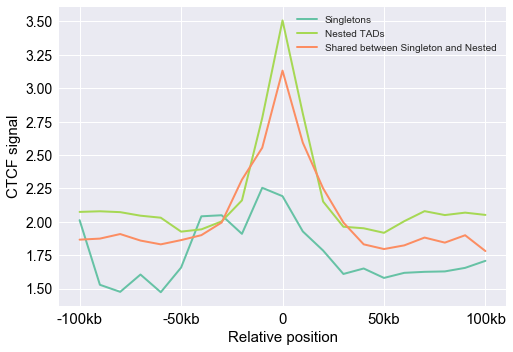

In [8]:
plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(out[0,:],c='#66c2a5',label='Singletons',linewidth=2)
ax.plot(out[1,:],c='#a6d854',label='Nested TADs',linewidth=2)
ax.plot(out[2,:],c='#fc8d62',label='Shared between Singleton and Nested',linewidth=2)
ax.legend(loc="upper right",prop={'size': 10})
#ax.axes.get_xaxis().set_visible(False)
plt.ylabel('CTCF signal', {'color': 'k', 'fontsize': 15})
plt.xlabel('Relative position', {'color': 'k', 'fontsize': 15})
plt.yticks(color='k',size=14)
plt.xticks((0,5,10,15,20),('-100kb','-50kb','0','50kb','100kb'),color='k',size=15)
plt.show()

In [9]:
cOnTAD_rawsoloball.shape, cOnTAD_rawhierball.shape, cOnTAD_rawoverball.shape

((790L, 21L), (8638L, 21L), (724L, 21L))

In [10]:
790+8638+724

10152

In [30]:
hierb[0]/hierb[1], solob[0]/solob[1], overb[0]/overb[1]

(0.37556299803672477, 0.16226415094339622, 0.37603305785123969)